### Notebook to check the tightness of the bound as a function of a time varying magnetic field
- Need to recalculate PI at each timestep (this changes W and the corresponding EP)

In [68]:
import numpy as np
import pandas as pd
import math
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import itertools
import scipy
import pickle
import thermo_tools


## Define global params
J = 1.
omega = 1/5. ## frequency of time varying magnetic field i.e. when t = 1/omega we have completed a cycle
Amp = 1.  ## amplitude of magnetic field

# beta_array = np.linspace(0.05,0.95,4)
beta = 0.15

n = 4
N_R = 1 ## number of random R matrices

### Get initial distribution p_0 (random)
n_steps = 500+1
t_array = np.linspace(0,50,n_steps)  ## temporal evolution
dt = t_array[1]-t_array[0]
p_0 = np.random.rand(np.power(2,n))
p_0 = p_0/np.sum(p_0)

## Calculate Magnetic Field
M = Amp*np.cos(2*np.pi*omega*t_array[0])
    
    

print("Analyzing beta = ",beta)



# ## For each random R matrix, get the difference in EP (actual - bound) at each timestep
results = []
for i in range(N_R):

    print("\t Analyzing R Matrix ",i,"...")

    ## Create a random symmetric R matrix
    L = np.tril(np.random.rand(np.power(2,n),np.power(2,n)),0)  # random lower triangle
    U = np.triu(np.transpose(L),1)  # reflect the transpose for the upper triangle
    R = np.copy(L+U) # combine

    ## Integrate forward in time
    def dp_dt(p_array,t):
                
        # Calculate magnetic field at t
        M = 1.*np.cos(2*np.pi*omega*t)
        
        # Get pi vector
        pi_vector = thermo_tools.get_pi_vector(n,beta,M,J)

        # Get W matrix
        W = thermo_tools.get_W(R,pi_vector)

        # Make sure columns of W sum to zero
        for col in range(np.power(2,n)):
            if np.abs(np.sum(W[:,col])) > 1e-14:
                print("ERROR - cols should sum to one",np.sum(W[col,:]))

        # Make sure local detailed balance is satisfied
        for xx in range(np.power(2,n)):
            for yy in range(np.power(2,n)):
                W_ij = W[xx,yy]
                P_j = pi_vector[yy]
                W_ji = W[yy,xx]
                P_i = pi_vector[xx]
                if not np.isclose(W_ij*P_j,W_ji*P_i):
                    print("ERROR - Local Detailed Balance Violated!")

        ## Calculate derivative
        dp_array = np.zeros(len(W))
        for A in range(len(W)):
            dp_m = 0.
            for B in range(len(W)):
                dp_m = dp_m + W[A][B]*p_array[B]
            dp_array[A]=dp_m
        if not np.isclose(np.sum(dp_array),0.0):
            print("ERROR PROB NOT CONSERVED!",np.sum(dp_array))
        return(dp_array)

    p_array = scipy.integrate.odeint(dp_dt,p_0,t_array)
    df = pd.DataFrame(p_array)

    ## Get difference between EP bound and EP actual at each timestep
    EP_bounds = []
    EP_actuals = []
    differences = []
    normed_differences = []
    convergence_flag = 0
    for j in range(len(df)-1):
        p_1 = df.loc[j,:]
        p_2 = df.loc[j+1,:]

        if np.isclose(p_1,p_2,rtol=1e-16,atol=1e-6).all() == True and convergence_flag==0:
            print("\t\t System converged at t = ",t_array[j])
            convergence_flag = 1


        ## Get EP Bound
        I_t0 = thermo_tools.I_Nstar(p_1,thermo_tools.get_units(n),n)
        I_tf = thermo_tools.I_Nstar(p_2,thermo_tools.get_units(n),n)
        EP_bound = -(I_tf-I_t0) ## this is the EP bound for this timestep
        EP_bounds.append(EP_bound)

        ## Get Actual EP
        t = t_array[j]
        M = 1.*np.cos(2*np.pi*omega*t)
        pi_vector = thermo_tools.get_pi_vector(n,beta,M,J)
        
        # Get W matrix
        W = thermo_tools.get_W(R,pi_vector)

        # Make sure columns sum to zero
        for col in range(np.power(2,n)):
            if np.abs(np.sum(W[:,col])) > 1e-14:
                print("ERROR - cols should sum to one",np.sum(W[col,:]))

        # Make sure local detailed balance is satisfied
        for xx in range(np.power(2,n)):
            for yy in range(np.power(2,n)):
                W_ij = W[xx,yy]
                P_j = pi_vector[yy]
                W_ji = W[yy,xx]
                P_i = pi_vector[xx]
                if not np.isclose(W_ij*P_j,W_ji*P_i):
                    print("ERROR - Local Detailed Balance Violated!")
        
        EP_actual = thermo_tools.get_EP(W,p_1,dt)
        EP_actuals.append(EP_actual)

        ## Get the difference
        differences.append(EP_actual-EP_bound)

        ## Get the relative tightness of the bound
        if np.abs(EP_actual-EP_bound)/EP_actual > 0.:
            normed_differences.append(np.abs(EP_actual-EP_bound)/EP_actual)
        else:
            normed_differences.append(0.)

    results.append(normed_differences)
    print("\t\t Results Appended.")

result_df = pd.DataFrame(results,columns=t_array[0:-1])

result_df.to_csv('beta_'+str(beta)+'_M_'+str(Amp)+'_normed.csv')

print("DONE")

Analyzing beta =  0.15
	 Analyzing R Matrix  0 ...
		 Results Appended.
DONE


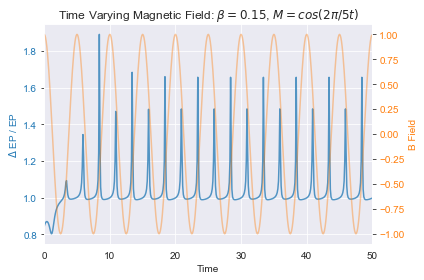

In [69]:
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline 

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel(r'$\Delta$ EP / EP', color=color)
ax1.plot(t_array[0:-1],normed_differences,color=color,alpha=0.75)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.set_ylabel('B Field', color=color)  # we already handled the x-label with ax1
ax2.plot(t_array[0:-1],Amp*np.cos(2*np.pi*omega*t_array[0:-1]),color=color,alpha=0.4)
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(False)

# x_values = [datetime.datetime(2020, 9, 10, 0, 0),datetime.datetime(2020, 9, 14, 0, 0),datetime.datetime(2020, 9, 18, 0, 0),
#             datetime.datetime(2020, 9, 22, 0, 0),datetime.datetime(2020, 9, 26, 0, 0),datetime.datetime(2020, 9, 30, 0, 0)]

# ax2.set_xticks(x_values)  # set tick locations
# ax2.set_xticklabels(['9/10/20','9/14/20','9/18/20','9/22/20','9/26/20','9/30/20'])  # set tick labels

plt.title(r'Time Varying Magnetic Field: $\beta = 0.15$, $M=cos(2\pi/5t)$')
plt.xlabel('Time')
# plt.ylabel(r'$\Delta$ EP / EP')
plt.xlim(0,50)
# plt.ylim(-1,2)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.savefig('time_varying_M1_beta'+str(beta)+'_4.pdf')
plt.show()

#### Now do three different temps for a single R matrix

In [81]:
import numpy as np
import pandas as pd
import math
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import itertools
import scipy
import pickle
import thermo_tools


## Define global params
J = 1.
omega = 1/5. ## frequency of time varying magnetic field i.e. when t = 1/omega we have completed a cycle
Amp = 1.  ## amplitude of magnetic field

beta_array = np.linspace(0.05,0.95,4)
# beta = 0.15

n = 4
N_R = 1 ## number of random R matrices

### Get initial distribution p_0 (random)
n_steps = 500+1
t_array = np.linspace(0,50,n_steps)  ## temporal evolution
dt = t_array[1]-t_array[0]
p_0 = np.random.rand(np.power(2,n))
p_0 = p_0/np.sum(p_0)

## Calculate Magnetic Field
M = Amp*np.cos(2*np.pi*omega*t_array[0])


# ## For each random R matrix, get the difference in EP (actual - bound) at each timestep
results = []
for i in range(N_R):

    print("Analyzing R Matrix ",i,"...")

    ## Create a random symmetric R matrix
    L = np.tril(np.random.rand(np.power(2,n),np.power(2,n)),0)  # random lower triangle
    U = np.triu(np.transpose(L),1)  # reflect the transpose for the upper triangle
    R = np.copy(L+U) # combine
    
    
    for beta in beta_array:
        
        print("\tAnalyzing beta = ",beta)

        ## Integrate forward in time
        def dp_dt(p_array,t):

            # Calculate magnetic field at t
            M = 1.*np.cos(2*np.pi*omega*t)

            # Get pi vector
            pi_vector = thermo_tools.get_pi_vector(n,beta,M,J)

            # Get W matrix
            W = thermo_tools.get_W(R,pi_vector)

            # Make sure columns of W sum to zero
            for col in range(np.power(2,n)):
                if np.abs(np.sum(W[:,col])) > 1e-14:
                    print("ERROR - cols should sum to one",np.sum(W[col,:]))

            # Make sure local detailed balance is satisfied
            for xx in range(np.power(2,n)):
                for yy in range(np.power(2,n)):
                    W_ij = W[xx,yy]
                    P_j = pi_vector[yy]
                    W_ji = W[yy,xx]
                    P_i = pi_vector[xx]
                    if not np.isclose(W_ij*P_j,W_ji*P_i):
                        print("ERROR - Local Detailed Balance Violated!")

            ## Calculate derivative
            dp_array = np.zeros(len(W))
            for A in range(len(W)):
                dp_m = 0.
                for B in range(len(W)):
                    dp_m = dp_m + W[A][B]*p_array[B]
                dp_array[A]=dp_m
            if not np.isclose(np.sum(dp_array),0.0):
                print("ERROR PROB NOT CONSERVED!",np.sum(dp_array))
            return(dp_array)

        p_array = scipy.integrate.odeint(dp_dt,p_0,t_array)
        df = pd.DataFrame(p_array)

        ## Get difference between EP bound and EP actual at each timestep
        EP_bounds = []
        EP_actuals = []
        differences = []
        normed_differences = []
        convergence_flag = 0
        for j in range(len(df)-1):
            p_1 = df.loc[j,:]
            p_2 = df.loc[j+1,:]

            if np.isclose(p_1,p_2,rtol=1e-16,atol=1e-6).all() == True and convergence_flag==0:
                print("\t\t System converged at t = ",t_array[j])
                convergence_flag = 1


            ## Get EP Bound
            I_t0 = thermo_tools.I_Nstar(p_1,thermo_tools.get_units(n),n)
            I_tf = thermo_tools.I_Nstar(p_2,thermo_tools.get_units(n),n)
            EP_bound = -(I_tf-I_t0) ## this is the EP bound for this timestep
            EP_bounds.append(EP_bound)

            ## Get Actual EP
            t = t_array[j]
            M = 1.*np.cos(2*np.pi*omega*t)
            pi_vector = thermo_tools.get_pi_vector(n,beta,M,J)

            # Get W matrix
            W = thermo_tools.get_W(R,pi_vector)

            # Make sure columns sum to zero
            for col in range(np.power(2,n)):
                if np.abs(np.sum(W[:,col])) > 1e-14:
                    print("ERROR - cols should sum to one",np.sum(W[col,:]))

            # Make sure local detailed balance is satisfied
            for xx in range(np.power(2,n)):
                for yy in range(np.power(2,n)):
                    W_ij = W[xx,yy]
                    P_j = pi_vector[yy]
                    W_ji = W[yy,xx]
                    P_i = pi_vector[xx]
                    if not np.isclose(W_ij*P_j,W_ji*P_i):
                        print("ERROR - Local Detailed Balance Violated!")

            EP_actual = thermo_tools.get_EP(W,p_1,dt)
            EP_actuals.append(EP_actual)

            ## Get the difference
            differences.append(EP_actual-EP_bound)

            ## Get the relative tightness of the bound
            if np.abs(EP_actual-EP_bound)/EP_actual > 0.:
                normed_differences.append(np.abs(EP_actual-EP_bound)/EP_actual)
            else:
                normed_differences.append(0.)

        results.append(normed_differences)
        print("\t\t Results Appended.")

    result_df = pd.DataFrame(results,columns=t_array[0:-1])

    result_df.to_csv('beta_'+str(beta)+'_M_'+str(Amp)+'_normed.csv')

    print("DONE")

Analyzing R Matrix  0 ...
	Analyzing beta =  0.05
		 Results Appended.
	Analyzing beta =  0.35
		 Results Appended.
	Analyzing beta =  0.65
		 Results Appended.
	Analyzing beta =  0.95
		 Results Appended.
DONE


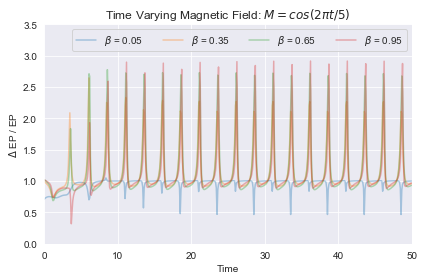

In [83]:
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline 

for i in range(len(beta_array)):
    beta = beta_array[i]
    beta_data = results[i][:]
    plt.plot(t_array[0:-1],beta_data,alpha=0.35,label=r'$\beta$ = {:.2f}'.format(beta))

    
plt.title(r'Time Varying Magnetic Field: $M=cos(2\pi t/5)$')
plt.xlabel('Time')
plt.ylabel(r'$\Delta$ EP / EP')
plt.xlim(0,50)
plt.ylim(0,3.5)
plt.legend(ncol=4,loc='best')
plt.tight_layout()
plt.savefig('time_varying_different_beta_2.pdf')
plt.show()

### Now check the bound for different amplitudes

In [90]:
import numpy as np
import pandas as pd
import math
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import itertools
import scipy
import pickle
import thermo_tools


## Define global params
J = 1.
omega = 1/5. ## frequency of time varying magnetic field i.e. when t = 1/omega we have completed a cycle
Amp = 1.  ## amplitude of magnetic field

# beta_array = np.linspace(0.05,0.95,4)
beta = 0.15
amp_array = [0.1,1,10]

n = 4
N_R = 1 ## number of random R matrices

### Get initial distribution p_0 (random)
n_steps = 500+1
t_array = np.linspace(0,50,n_steps)  ## temporal evolution
dt = t_array[1]-t_array[0]
p_0 = np.random.rand(np.power(2,n))
p_0 = p_0/np.sum(p_0)

## Calculate Magnetic Field
M = amp_array[0]*np.cos(2*np.pi*omega*t_array[0])


# ## For each random R matrix, get the difference in EP (actual - bound) at each timestep
results = []
for i in range(N_R):

    print("Analyzing R Matrix ",i,"...")

    ## Create a random symmetric R matrix
    L = np.tril(np.random.rand(np.power(2,n),np.power(2,n)),0)  # random lower triangle
    U = np.triu(np.transpose(L),1)  # reflect the transpose for the upper triangle
    R = np.copy(L+U) # combine
    
    
    for amp in amp_array:
        
        print("\tAnalyzing amplitude = ",amp)

        ## Integrate forward in time
        def dp_dt(p_array,t):

            # Calculate magnetic field at t
            M = amp*np.cos(2*np.pi*omega*t)

            # Get pi vector
            pi_vector = thermo_tools.get_pi_vector(n,beta,M,J)

            # Get W matrix
            W = thermo_tools.get_W(R,pi_vector)

            # Make sure columns of W sum to zero
            for col in range(np.power(2,n)):
                if np.abs(np.sum(W[:,col])) > 1e-14:
                    print("ERROR - cols should sum to one",np.sum(W[col,:]))

            # Make sure local detailed balance is satisfied
            for xx in range(np.power(2,n)):
                for yy in range(np.power(2,n)):
                    W_ij = W[xx,yy]
                    P_j = pi_vector[yy]
                    W_ji = W[yy,xx]
                    P_i = pi_vector[xx]
                    if not np.isclose(W_ij*P_j,W_ji*P_i):
                        print("ERROR - Local Detailed Balance Violated!")

            ## Calculate derivative
            dp_array = np.zeros(len(W))
            for A in range(len(W)):
                dp_m = 0.
                for B in range(len(W)):
                    dp_m = dp_m + W[A][B]*p_array[B]
                dp_array[A]=dp_m
            if not np.isclose(np.sum(dp_array),0.0):
                print("ERROR PROB NOT CONSERVED!",np.sum(dp_array))
            return(dp_array)

        p_array = scipy.integrate.odeint(dp_dt,p_0,t_array)
        df = pd.DataFrame(p_array)

        ## Get difference between EP bound and EP actual at each timestep
        EP_bounds = []
        EP_actuals = []
        differences = []
        normed_differences = []
        convergence_flag = 0
        for j in range(len(df)-1):
            p_1 = df.loc[j,:]
            p_2 = df.loc[j+1,:]

            if np.isclose(p_1,p_2,rtol=1e-16,atol=1e-6).all() == True and convergence_flag==0:
                print("\t\t System converged at t = ",t_array[j])
                convergence_flag = 1


            ## Get EP Bound
            I_t0 = thermo_tools.I_Nstar(p_1,thermo_tools.get_units(n),n)
            I_tf = thermo_tools.I_Nstar(p_2,thermo_tools.get_units(n),n)
            EP_bound = -(I_tf-I_t0) ## this is the EP bound for this timestep
            EP_bounds.append(EP_bound)

            ## Get Actual EP
            t = t_array[j]
            M = amp*np.cos(2*np.pi*omega*t)
            pi_vector = thermo_tools.get_pi_vector(n,beta,M,J)

            # Get W matrix
            W = thermo_tools.get_W(R,pi_vector)

            # Make sure columns sum to zero
            for col in range(np.power(2,n)):
                if np.abs(np.sum(W[:,col])) > 1e-14:
                    print("ERROR - cols should sum to one",np.sum(W[col,:]))

            # Make sure local detailed balance is satisfied
            for xx in range(np.power(2,n)):
                for yy in range(np.power(2,n)):
                    W_ij = W[xx,yy]
                    P_j = pi_vector[yy]
                    W_ji = W[yy,xx]
                    P_i = pi_vector[xx]
                    if not np.isclose(W_ij*P_j,W_ji*P_i):
                        print("ERROR - Local Detailed Balance Violated!")

            EP_actual = thermo_tools.get_EP(W,p_1,dt)
            EP_actuals.append(EP_actual)

            ## Get the difference
            differences.append(EP_actual-EP_bound)

            ## Get the relative tightness of the bound
            if np.abs(EP_actual-EP_bound)/EP_actual > 0.:
                normed_differences.append(np.abs(EP_actual-EP_bound)/EP_actual)
            else:
                normed_differences.append(0.)

        results.append(normed_differences)
        print("\t\t Results Appended.")

    result_df = pd.DataFrame(results,columns=t_array[0:-1])

    result_df.to_csv('beta_'+str(beta)+'_M_'+str(Amp)+'_normed.csv')

    print("DONE")

Analyzing R Matrix  0 ...
	Analyzing amplitude =  0.1
		 Results Appended.
	Analyzing amplitude =  1
		 Results Appended.
	Analyzing amplitude =  10
		 Results Appended.
DONE


Minimum is  0.11440999984059955
Minimum is  0.739534076698836
Minimum is  0.8180581572465087


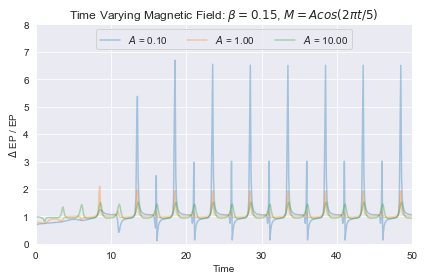

In [92]:
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline 

for i in range(len(amp_array)):
    amp = amp_array[i]
    amp_data = results[i][:]
    print("Minimum is ",np.min(amp_data))
    plt.plot(t_array[0:-1],amp_data,alpha=0.35,label=r'$A$ = {:.2f}'.format(amp))

    
plt.title(r'Time Varying Magnetic Field: $\beta = 0.15$, $M=Acos(2\pi t/5)$')
plt.xlabel('Time')
plt.ylabel(r'$\Delta$ EP / EP')
plt.xlim(0,50)
plt.ylim(0,8)
plt.legend(ncol=3,loc='upper center')
plt.tight_layout()
# plt.savefig('time_varying_different_amp_2.pdf')
plt.show()